In [472]:
# import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from sklearn import ensemble, preprocessing
%matplotlib inline
# Import baseline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Importing Datasets

In [319]:
Train=pd.read_csv('data/train.csv')
Test=pd.read_csv('data/test.csv')
Spray=pd.read_csv('data/spray.csv')
Weather=pd.read_csv('data/weather.csv')

# Data Wrangling and EDA

<h3>Train dataset:

In [320]:
Train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [321]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


<h3>Step 1. <br>Street, address, block, AddressNumberAndStreet and AddressAccuracy should be removed

In [322]:
Train.drop(['Street', 'Address', 'Block', 'AddressNumberAndStreet', 'AddressAccuracy'],axis=1,inplace=True)

<h3>Step2.<br>Convert the date to Datetime object

In [323]:
def date_fixer(df):
    df['Date']=pd.to_datetime(df['Date'])
    df['Year']=df.Date.dt.year
    df['Month']=df.Date.dt.month
    df['Day']=df.Date.dt.day

In [324]:
date_fixer(Train)

In [325]:
Train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,29
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5,29
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,5,29


<h3>The target is to find the correlation between different columns and WnvPresent:

In [326]:
Train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

<h3>Step 3.<br>PIPIENS/RESTUANS, which the most popular category in dataset, contains RESTUANS "OR" PIPIENS, so it is better to replace PIPIENS and RESTUANS columns with PIPIENS/RESTUANS

In [327]:
Train.Species.replace(['CULEX RESTUANS','CULEX PIPIENS'],'CULEX PIPIENS/RESTUANS', inplace=True)

[Text(0, 0, 'CULEX ERRATICUS'),
 Text(1, 0, 'CULEX PIPIENS/RESTUANS'),
 Text(2, 0, 'CULEX SALINARIUS'),
 Text(3, 0, 'CULEX TARSALIS'),
 Text(4, 0, 'CULEX TERRITANS')]

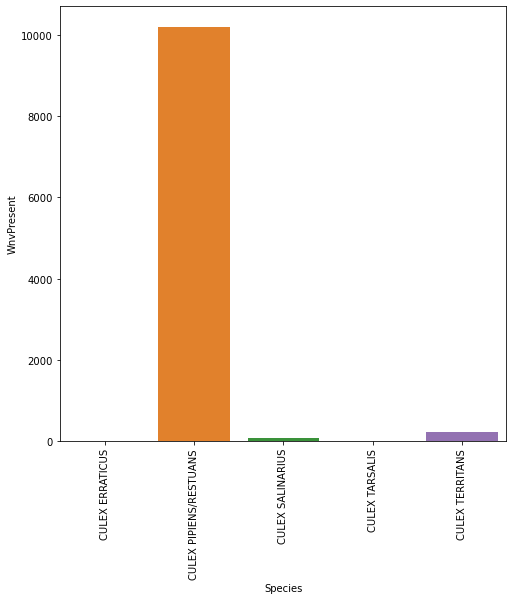

In [328]:
temp=Train.groupby('Species').count()
temp.head(3)
fig,ax=plt.subplots(figsize=(8,8))
sns.barplot(x=temp.index,y=temp.WnvPresent)
ax.set_xticklabels(temp.index,rotation=90)

<h4>PIPIENS/RESTUANS are the most probable types of species for being infected<br> Step. 4:<br>I will add a column wich contains "1" for these species, and "0" for the rest

In [329]:
for n,v in enumerate(Train.Species):
    if v=='CULEX PIPIENS/RESTUANS':
        Train.loc[n,'MP_Species']=1
    else:
        Train.loc[n,'MP_Species']=0
            

In [330]:
Train.MP_Species.value_counts()

1.0    10191
0.0      315
Name: MP_Species, dtype: int64

<h3>For investigating the traps, I will add a column including location data of each trap<br>Step. 5:

In [331]:
Train['Location']=list(zip(Train['Longitude'],Train['Latitude']))

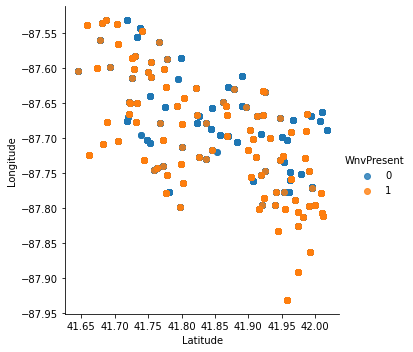

In [332]:
sns.lmplot(x='Latitude',y='Longitude',data=Train,hue='WnvPresent',fit_reg=False)

In [333]:
temp=Train.groupby('Trap').count().reset_index().head(20).sort_values(by='WnvPresent',ascending=False)
temp.head()
MP_Trap=list(temp.Trap)

<module 'matplotlib.pyplot' from 'C:\\Users\\Shaqayeq\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

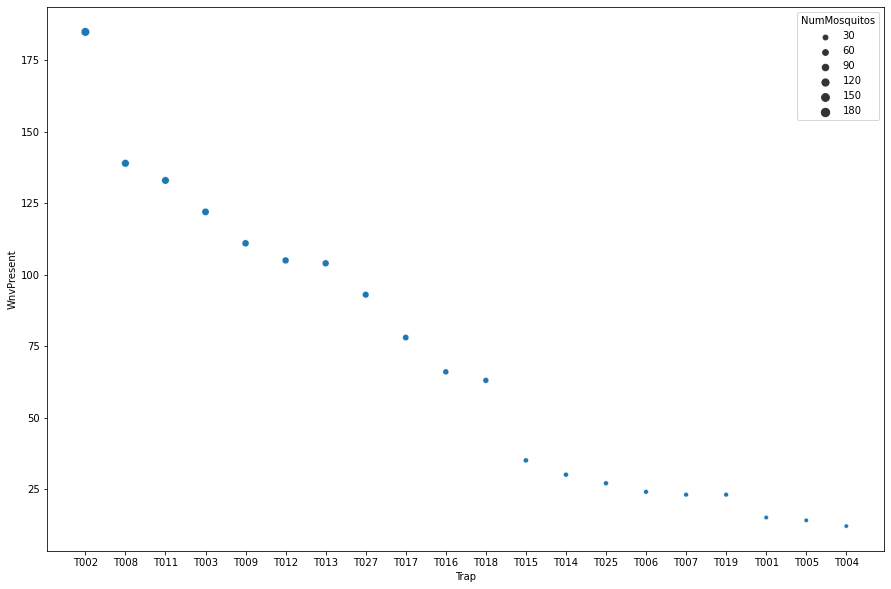

In [334]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='Trap',y='WnvPresent',size='NumMosquitos',data=temp)
plt

## The first 20 Traps, show the most number of traped mosquitos and most number of the reported infection, obviously there is a linear correlation between number of traped mosquitos and amount of infection! 

### Step. 6:<br>Let's check the location of those traps! Beacuse the huge amount of mosquitos in those traps could be because of environmental situation around those traps, such as polution or i.e. number of trash cans in those regions

In [335]:
# Adding a column to Train dataset, MP_Trap, equal to 1 for those first 20 traps, and 0 for the rest
Train['MP_Trap']=Train.Trap.isin(MP_Trap).astype('int')

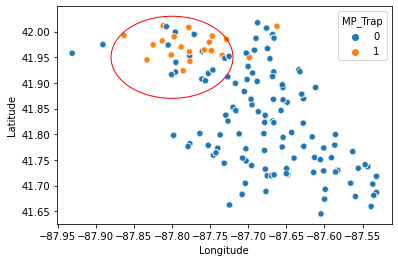

In [336]:
#Check the location of Traps:
ax=sns.scatterplot(y="Latitude",x="Longitude",hue='MP_Trap',data=Train)
circle=plt.Circle(xy=(-87.8,41.95),radius=0.08,color='red',fill=False)
ax.add_patch(circle)

The Traps, with most insident of mosquitos and also infection, are located in the region showed by red circle. That could be because of the weather condition in that region, or environmental polution. By the way, I have added a column to Train dataset to give those traps a weight

### Step 7.<br>Checking the presense of virus in various months of the year

In [337]:
prob_date=Train.groupby(['Month','Day']).count().sort_values(by='WnvPresent',ascending=False).reset_index()
prob_date.head()

,Month,Day,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,MP_Species,Location,MP_Trap
0,8,1,737,737,737,737,737,737,737,737,737,737,737
1,8,15,433,433,433,433,433,433,433,433,433,433,433
2,7,25,424,424,424,424,424,424,424,424,424,424,424
3,9,12,412,412,412,412,412,412,412,412,412,412,412
4,8,7,315,315,315,315,315,315,315,315,315,315,315


<AxesSubplot:xlabel='Month', ylabel='WnvPresent'>

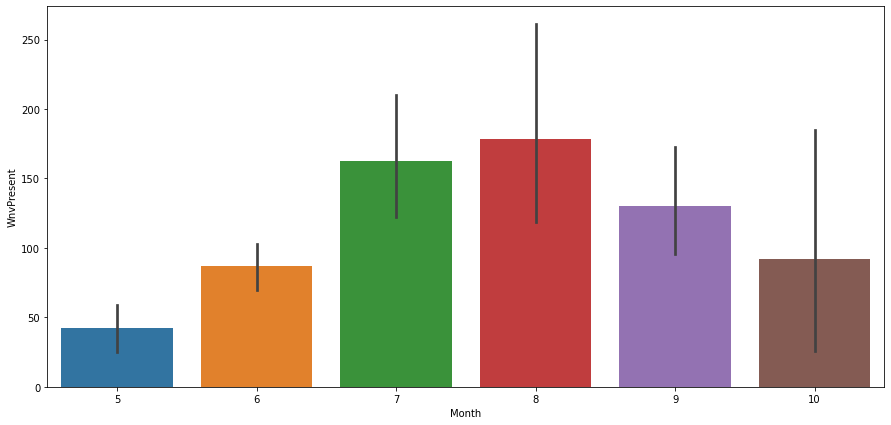

In [338]:
plt.figure(figsize=(15,7))
sns.barplot(x='Month',y='WnvPresent',data=prob_date)

In [339]:
Train['MP_month']=Train['Month'].isin([6,7,8,9,10]).astype('int')
Train['MP_month']

0        0
1        0
2        0
3        0
4        0
        ..
10501    1
10502    1
10503    1
10504    1
10505    1
Name: MP_month, Length: 10506, dtype: int32

In [340]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10506 non-null  datetime64[ns]
 1   Species       10506 non-null  object        
 2   Trap          10506 non-null  object        
 3   Latitude      10506 non-null  float64       
 4   Longitude     10506 non-null  float64       
 5   NumMosquitos  10506 non-null  int64         
 6   WnvPresent    10506 non-null  int64         
 7   Year          10506 non-null  int64         
 8   Month         10506 non-null  int64         
 9   Day           10506 non-null  int64         
 10  MP_Species    10506 non-null  float64       
 11  Location      10506 non-null  object        
 12  MP_Trap       10506 non-null  int32         
 13  MP_month      10506 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(5), object(3)
memory usage: 1.0+ MB


# Check the Test dataset and and compare it with Train:

In [341]:
Test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [342]:
# Control the different columns:
set(Test.columns)-set(Train.columns)

{'Address',
 'AddressAccuracy',
 'AddressNumberAndStreet',
 'Block',
 'Id',
 'Street'}

<h3> Step 1. <br>Street, address, block, AddressNumberAndStreet, Id and AddressAccuracy should be removed

In [343]:
Test.drop(['Address','AddressAccuracy','AddressNumberAndStreet','Block','Id','Street'],axis=1,inplace=True)

In [344]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       116293 non-null  object 
 1   Species    116293 non-null  object 
 2   Trap       116293 non-null  object 
 3   Latitude   116293 non-null  float64
 4   Longitude  116293 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.4+ MB


<h3>Step2.<br>Convert the date to Datetime object

In [345]:
date_fixer(Test)

<h3>Step 3: fixing the Species

In [346]:
Test.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [347]:
Test.Species.replace(['CULEX RESTUANS','CULEX PIPIENS'],'CULEX PIPIENS/RESTUANS', inplace=True)

In [348]:
set(Test.Species.unique())-set(Train.Species.unique())

{'UNSPECIFIED CULEX'}

There is a virus type named UNSPECIFIED in Test dataset, which can not be predicted fro Train dataset, but since the outbreak case is very important, and treatment cost is much higher than spraying cost, I will replace them with the type which is most probable to be infectious 

In [349]:
Test.Species.replace(['UNSPECIFIED CULEX'],'CULEX PIPIENS/RESTUANS', inplace=True)

In [350]:
list(set(Test.Trap.unique())-set(Train.Trap.unique()))


['T128A',
 'T200B',
 'T218B',
 'T002A',
 'T234',
 'T090A',
 'T002B',
 'T200A',
 'T090B',
 'T218A',
 'T090C',
 'T218C',
 'T065A']

In [351]:
Test = Test[Test.Trap != 'T234']

In [352]:
Test.Trap.replace({'T218B':'T218','T090C':'T090','T128A':'T128','T002B':'T002','T065A':'T065','T090B':'T090','T218A':'T218','T200B':'T200','T002A':'T002','T218C':'T218','T090A':'T090','T200A':'T200'},inplace=True)

<h2>Alert

#There is one trap in test set that does not exist in train set,let's add this trap to train datset:
Train.head()

## Spray dataset

In [353]:
Spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [354]:
Spray.isna().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [355]:
# Since we do not consider the time of the spray, let's get rid of that
Spray.drop('Time',axis=1,inplace=True)
Spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [356]:
date_fixer(Spray)

# Weather dataset

In [357]:
Weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [358]:
Weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [359]:
date_fixer(Weather)

In [360]:
Weather.isna().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
Year           0
Month          0
Day            0
dtype: int64

In [361]:
# Checking the missing values:
def miss_checker (df):
    missings={}
    for col in df.columns:
        num=[pd.Series(df[col]=='M').sum(),pd.Series(df[col]=='-').sum(),pd.Series(df[col]=='  T').sum(),pd.Series(df[col]==' ').sum()]
        missings[col]=num
    
    return missings
        #print("The missing value in column " + str(col)+ " is: " +"\n"+ str(num))

In [362]:
print(Weather.shape)
miss_checker(Weather)

(2944, 25)


{'Station': [0, 0, 0, 0],
 'Date': [0, 0, 0, 0],
 'Tmax': [0, 0, 0, 0],
 'Tmin': [0, 0, 0, 0],
 'Tavg': [11, 0, 0, 0],
 'Depart': [1472, 0, 0, 0],
 'DewPoint': [0, 0, 0, 0],
 'WetBulb': [4, 0, 0, 0],
 'Heat': [11, 0, 0, 0],
 'Cool': [11, 0, 0, 0],
 'Sunrise': [0, 1472, 0, 0],
 'Sunset': [0, 1472, 0, 0],
 'CodeSum': [0, 0, 0, 1609],
 'Depth': [1472, 0, 0, 0],
 'Water1': [2944, 0, 0, 0],
 'SnowFall': [1472, 0, 12, 0],
 'PrecipTotal': [2, 0, 318, 0],
 'StnPressure': [4, 0, 0, 0],
 'SeaLevel': [9, 0, 0, 0],
 'ResultSpeed': [0, 0, 0, 0],
 'ResultDir': [0, 0, 0, 0],
 'AvgSpeed': [3, 0, 0, 0],
 'Year': [0, 0, 0, 0],
 'Month': [0, 0, 0, 0],
 'Day': [0, 0, 0, 0]}

In [363]:
# The info come from two different weather station, which could be helpful to find missing values
Weather['Station'].value_counts()

1    1472
2    1472
Name: Station, dtype: int64

In [364]:
# First separate data from two different stations
Weather_s1=Weather[Weather['Station']==1]
Weather_s2=Weather[Weather['Station']==2]

In [365]:
# Merge the separated data
Weather_m=Weather_s1.merge(Weather_s2, on='Date',suffixes=('_s1', '_s2'))
Weather_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Station_s1      1472 non-null   int64         
 1   Date            1472 non-null   datetime64[ns]
 2   Tmax_s1         1472 non-null   int64         
 3   Tmin_s1         1472 non-null   int64         
 4   Tavg_s1         1472 non-null   object        
 5   Depart_s1       1472 non-null   object        
 6   DewPoint_s1     1472 non-null   int64         
 7   WetBulb_s1      1472 non-null   object        
 8   Heat_s1         1472 non-null   object        
 9   Cool_s1         1472 non-null   object        
 10  Sunrise_s1      1472 non-null   object        
 11  Sunset_s1       1472 non-null   object        
 12  CodeSum_s1      1472 non-null   object        
 13  Depth_s1        1472 non-null   object        
 14  Water1_s1       1472 non-null   object        
 15  Snow

In [366]:
print((Weather_m['Tavg_s1']=='M').sum())
print((Weather_m['Tavg_s2']=='M').sum())

0
11


In [367]:
# Replace the missing average temperature with mean of min and max temperature
for n,v in enumerate(Weather_m['Tavg_s2']):
    if v == 'M':
        Weather_m.loc[n,'Tavg_s2']=(Weather_m.loc[n,'Tmin_s2']+Weather_m.loc[n,'Tmax_s2'])/2
(Weather_m['Tavg_s2']=='M').sum()

0

In [368]:
# Checking the missing values of the merged weather data frame
miss_checker(Weather_m)
# Some columns miss the whole values:
miss_columns=['Water1_s1','Depart_s2','Sunrise_s2','Sunset_s2','Depth_s2','Water1_s2','SnowFall_s2']
Weather_m.drop(miss_columns,axis=1,inplace=True)
miss_checker(Weather_m)

{'Station_s1': [0, 0, 0, 0],
 'Date': [0, 0, 0, 0],
 'Tmax_s1': [0, 0, 0, 0],
 'Tmin_s1': [0, 0, 0, 0],
 'Tavg_s1': [0, 0, 0, 0],
 'Depart_s1': [0, 0, 0, 0],
 'DewPoint_s1': [0, 0, 0, 0],
 'WetBulb_s1': [3, 0, 0, 0],
 'Heat_s1': [0, 0, 0, 0],
 'Cool_s1': [0, 0, 0, 0],
 'Sunrise_s1': [0, 0, 0, 0],
 'Sunset_s1': [0, 0, 0, 0],
 'CodeSum_s1': [0, 0, 0, 805],
 'Depth_s1': [0, 0, 0, 0],
 'SnowFall_s1': [0, 0, 12, 0],
 'PrecipTotal_s1': [0, 0, 163, 0],
 'StnPressure_s1': [2, 0, 0, 0],
 'SeaLevel_s1': [5, 0, 0, 0],
 'ResultSpeed_s1': [0, 0, 0, 0],
 'ResultDir_s1': [0, 0, 0, 0],
 'AvgSpeed_s1': [0, 0, 0, 0],
 'Year_s1': [0, 0, 0, 0],
 'Month_s1': [0, 0, 0, 0],
 'Day_s1': [0, 0, 0, 0],
 'Station_s2': [0, 0, 0, 0],
 'Tmax_s2': [0, 0, 0, 0],
 'Tmin_s2': [0, 0, 0, 0],
 'Tavg_s2': [0, 0, 0, 0],
 'DewPoint_s2': [0, 0, 0, 0],
 'WetBulb_s2': [1, 0, 0, 0],
 'Heat_s2': [11, 0, 0, 0],
 'Cool_s2': [11, 0, 0, 0],
 'CodeSum_s2': [0, 0, 0, 804],
 'PrecipTotal_s2': [2, 0, 155, 0],
 'StnPressure_s2': [2, 0, 0, 

In [369]:
# replacing the missing data from one station, with data of another station
for n, v in enumerate(Weather_m['WetBulb_s1']):
    if v == 'M':
        Weather_m.loc[n,'WetBulb_s1']=Weather_m.loc[n,'WetBulb_s2']
print((Weather_m['WetBulb_s1']=='M').sum()) 

0


In [370]:
for n, v in enumerate(Weather_m['WetBulb_s2']):
    if v == 'M':
        Weather_m.loc[n,'WetBulb_s2']=Weather_m.loc[n,'WetBulb_s1']
print((Weather_m['WetBulb_s2']=='M').sum()) 

0


In [371]:
# Columns SnowFall_s1 has 12 'T' values, There is no Snowfall report from other station
print(Weather_m['SnowFall_s1'].value_counts())
# Bacause of huge number of 0.0 value, I prefer to drop this column
Weather_m.drop('SnowFall_s1',axis=1,inplace=True)

0.0    1459
  T      12
0.1       1
Name: SnowFall_s1, dtype: int64


In [372]:
#Cleaning data of PrecipTotal columns:
print("Number of 'T' values in PreceipTotal column (S1) before cleaning: " + str((Weather_m['PrecipTotal_s1']=='  T').sum()))
print("Number of 'T' values in PreceipTotal column (S2) before cleaning: " + str((Weather_m['PrecipTotal_s2']=='  T').sum()))

Number of 'T' values in PreceipTotal column (S1) before cleaning: 163
Number of 'T' values in PreceipTotal column (S2) before cleaning: 155


In [373]:
for n, v in enumerate(Weather_m['PrecipTotal_s1']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'PrecipTotal_s1']=Weather_m.loc[n,'PrecipTotal_s2']
# Repeating the same procedure for the data from other station:
for n, v in enumerate(Weather_m['PrecipTotal_s2']):
    if v == '  T' or v=="M":
        Weather_m.loc[n,'PrecipTotal_s2']=Weather_m.loc[n,'PrecipTotal_s1']


In [374]:
print("Number of 'T' values in PreceipTotal column (S1) after cleaning: " + str((Weather_m['PrecipTotal_s1']=='  T').sum()))
print("Number of 'T' values in PreceipTotal column (S2) after cleaning: " + str((Weather_m['PrecipTotal_s2']=='  T').sum()))

Number of 'T' values in PreceipTotal column (S1) after cleaning: 64
Number of 'T' values in PreceipTotal column (S2) after cleaning: 64


In [375]:
# There 64 missing data from both columns that need to be taken care of:
Weather_m['PrecipTotal_s1'].unique()
Q=pd.DataFrame(Weather_m['PrecipTotal_s1'][Weather_m['PrecipTotal_s1']!='  T'].value_counts()).reset_index().rename(columns={'index':'Variables','PrecipTotal_s1':'Count'})
Q2=Q=pd.DataFrame(Weather_m['PrecipTotal_s2'][Weather_m['PrecipTotal_s2']!='  T'].value_counts()).reset_index().rename(columns={'index':'Variables','PrecipTotal_s2':'Count'})


In [376]:
#Finding the suitable value for replacing with the missing data 
print(Q['Variables'].astype('float').quantile(q=[0.25,0.5,0.75]))
Q2['Variables'].astype('float').quantile(q=[0.25,0.5,0.75])

0.25    0.32
0.50    0.64
0.75    1.14
Name: Variables, dtype: float64


0.25    0.32
0.50    0.64
0.75    1.14
Name: Variables, dtype: float64

In [377]:
# Replacing the last piece of missing Data 
Weather_m['PrecipTotal_s1'].replace('  T',0.6,inplace=True)
Weather_m['PrecipTotal_s2'].replace('  T',0.6,inplace=True)

In [378]:
for n, v in enumerate(Weather_m['StnPressure_s1']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'StnPressure_s1']=Weather_m.loc[n,'StnPressure_s2']
# Repeating the same procedure for the data from other station:
for n, v in enumerate(Weather_m['StnPressure_s2']):
    if v == '  T' or v=="M":
        Weather_m.loc[n,'StnPressure_s2']=Weather_m.loc[n,'StnPressure_s1']
print("Missing from StnPressure of station 1: "+ str((Weather_m['StnPressure_s1']=='M').sum()))
print("Missing from StnPressure of station 2: "+ str((Weather_m['StnPressure_s2']=='M').sum()))

Missing from StnPressure of station 1: 1
Missing from StnPressure of station 2: 1


In [379]:
print(Weather_m['StnPressure_s1'][Weather_m['StnPressure_s1']!='M'].median())
print(Weather_m['StnPressure_s2'][Weather_m['StnPressure_s2']!='M'].median())
Weather_m['StnPressure_s1'].replace('M',29,inplace=True)
Weather_m['StnPressure_s2'].replace('M',29,inplace=True)

29.26
29.32


In [380]:
for n, v in enumerate(Weather_m['Heat_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'Heat_s2']=Weather_m.loc[n,'Heat_s1']
for n, v in enumerate(Weather_m['Cool_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'Cool_s2']=Weather_m.loc[n,'Cool_s1']
for n, v in enumerate(Weather_m['AvgSpeed_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'AvgSpeed_s2']=Weather_m.loc[n,'AvgSpeed_s1']
        

In [381]:
for n, v in enumerate(Weather_m['SeaLevel_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'SeaLevel_s2']=Weather_m.loc[n,'SeaLevel_s1']
for n, v in enumerate(Weather_m['SeaLevel_s1']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'SeaLevel_s1']=Weather_m.loc[n,'SeaLevel_s2']

In [382]:
for n, v in enumerate(Weather_m['CodeSum_s1']):
    if v == '  T' or v==' ':
        Weather_m.loc[n,'CodeSum_s1']=Weather_m.loc[n,'CodeSum_s2']
for n, v in enumerate(Weather_m['SeaLevel_s2']):
    if v == '  T' or v==' ':
        Weather_m.loc[n,'CodeSum_s2']=Weather_m.loc[n,'CodeSum_s1']

In [383]:
miss_checker(Weather_m)

{'Station_s1': [0, 0, 0, 0],
 'Date': [0, 0, 0, 0],
 'Tmax_s1': [0, 0, 0, 0],
 'Tmin_s1': [0, 0, 0, 0],
 'Tavg_s1': [0, 0, 0, 0],
 'Depart_s1': [0, 0, 0, 0],
 'DewPoint_s1': [0, 0, 0, 0],
 'WetBulb_s1': [0, 0, 0, 0],
 'Heat_s1': [0, 0, 0, 0],
 'Cool_s1': [0, 0, 0, 0],
 'Sunrise_s1': [0, 0, 0, 0],
 'Sunset_s1': [0, 0, 0, 0],
 'CodeSum_s1': [0, 0, 0, 717],
 'Depth_s1': [0, 0, 0, 0],
 'PrecipTotal_s1': [0, 0, 0, 0],
 'StnPressure_s1': [0, 0, 0, 0],
 'SeaLevel_s1': [0, 0, 0, 0],
 'ResultSpeed_s1': [0, 0, 0, 0],
 'ResultDir_s1': [0, 0, 0, 0],
 'AvgSpeed_s1': [0, 0, 0, 0],
 'Year_s1': [0, 0, 0, 0],
 'Month_s1': [0, 0, 0, 0],
 'Day_s1': [0, 0, 0, 0],
 'Station_s2': [0, 0, 0, 0],
 'Tmax_s2': [0, 0, 0, 0],
 'Tmin_s2': [0, 0, 0, 0],
 'Tavg_s2': [0, 0, 0, 0],
 'DewPoint_s2': [0, 0, 0, 0],
 'WetBulb_s2': [0, 0, 0, 0],
 'Heat_s2': [0, 0, 0, 0],
 'Cool_s2': [0, 0, 0, 0],
 'CodeSum_s2': [0, 0, 0, 804],
 'PrecipTotal_s2': [0, 0, 0, 0],
 'StnPressure_s2': [0, 0, 0, 0],
 'SeaLevel_s2': [0, 0, 0, 0],
 'R

In [384]:
def dfto_numeric (df):
    for col in df.columns:
        if col!='Date':
            df[col]=pd.to_numeric(df[col])

In [385]:
Weather_m[Weather_m==" "].count()

Station_s1          0
Date                0
Tmax_s1             0
Tmin_s1             0
Tavg_s1             0
Depart_s1           0
DewPoint_s1         0
WetBulb_s1          0
Heat_s1             0
Cool_s1             0
Sunrise_s1          0
Sunset_s1           0
CodeSum_s1        717
Depth_s1            0
PrecipTotal_s1      0
StnPressure_s1      0
SeaLevel_s1         0
ResultSpeed_s1      0
ResultDir_s1        0
AvgSpeed_s1         0
Year_s1             0
Month_s1            0
Day_s1              0
Station_s2          0
Tmax_s2             0
Tmin_s2             0
Tavg_s2             0
DewPoint_s2         0
WetBulb_s2          0
Heat_s2             0
Cool_s2             0
CodeSum_s2        804
PrecipTotal_s2      0
StnPressure_s2      0
SeaLevel_s2         0
ResultSpeed_s2      0
ResultDir_s2        0
AvgSpeed_s2         0
Year_s2             0
Month_s2            0
Day_s2              0
dtype: int64

In [386]:
Weather_m.drop(['CodeSum_s2','CodeSum_s1'],axis=1,inplace=True)

In [387]:
dfto_numeric(Weather_m)

## Combine weather with train dataset

In [388]:
df_train=Train.merge(Weather_m,on='Date')

In [389]:
df_train.shape

(10506, 52)

## Combine weather with test dataset

In [390]:
df_test=Test.merge(Weather_m,on='Date')

In [391]:
df_test.shape

(115533, 46)

In [392]:
df_test.head()

,Date,Species,Trap,Latitude,Longitude,Year,Month,Day,Station_s1,Tmax_s1,...,Cool_s2,PrecipTotal_s2,StnPressure_s2,SeaLevel_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,Year_s2,Month_s2,Day_s2
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,11,1,86,...,11,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,11,1,86,...,11,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
2,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,11,1,86,...,11,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,11,1,86,...,11,0.0,29.34,29.97,9.4,18,10.4,2008,6,11
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,11,1,86,...,11,0.0,29.34,29.97,9.4,18,10.4,2008,6,11


## Checking the weather info on df_train, to check correlation between data and infection

In [393]:
df_train.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Year', 'Month', 'Day', 'MP_Species', 'Location',
       'MP_Trap', 'MP_month', 'Station_s1', 'Tmax_s1', 'Tmin_s1', 'Tavg_s1',
       'Depart_s1', 'DewPoint_s1', 'WetBulb_s1', 'Heat_s1', 'Cool_s1',
       'Sunrise_s1', 'Sunset_s1', 'Depth_s1', 'PrecipTotal_s1',
       'StnPressure_s1', 'SeaLevel_s1', 'ResultSpeed_s1', 'ResultDir_s1',
       'AvgSpeed_s1', 'Year_s1', 'Month_s1', 'Day_s1', 'Station_s2', 'Tmax_s2',
       'Tmin_s2', 'Tavg_s2', 'DewPoint_s2', 'WetBulb_s2', 'Heat_s2', 'Cool_s2',
       'PrecipTotal_s2', 'StnPressure_s2', 'SeaLevel_s2', 'ResultSpeed_s2',
       'ResultDir_s2', 'AvgSpeed_s2', 'Year_s2', 'Month_s2', 'Day_s2'],
      dtype='object')

In [394]:
df_train.drop(['Year_s1','Month_s1','Day_s1','Year_s2','Month_s2','Day_s2','Station_s1','Station_s2'],axis=1,inplace=True)

## Effect of temperature

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaq

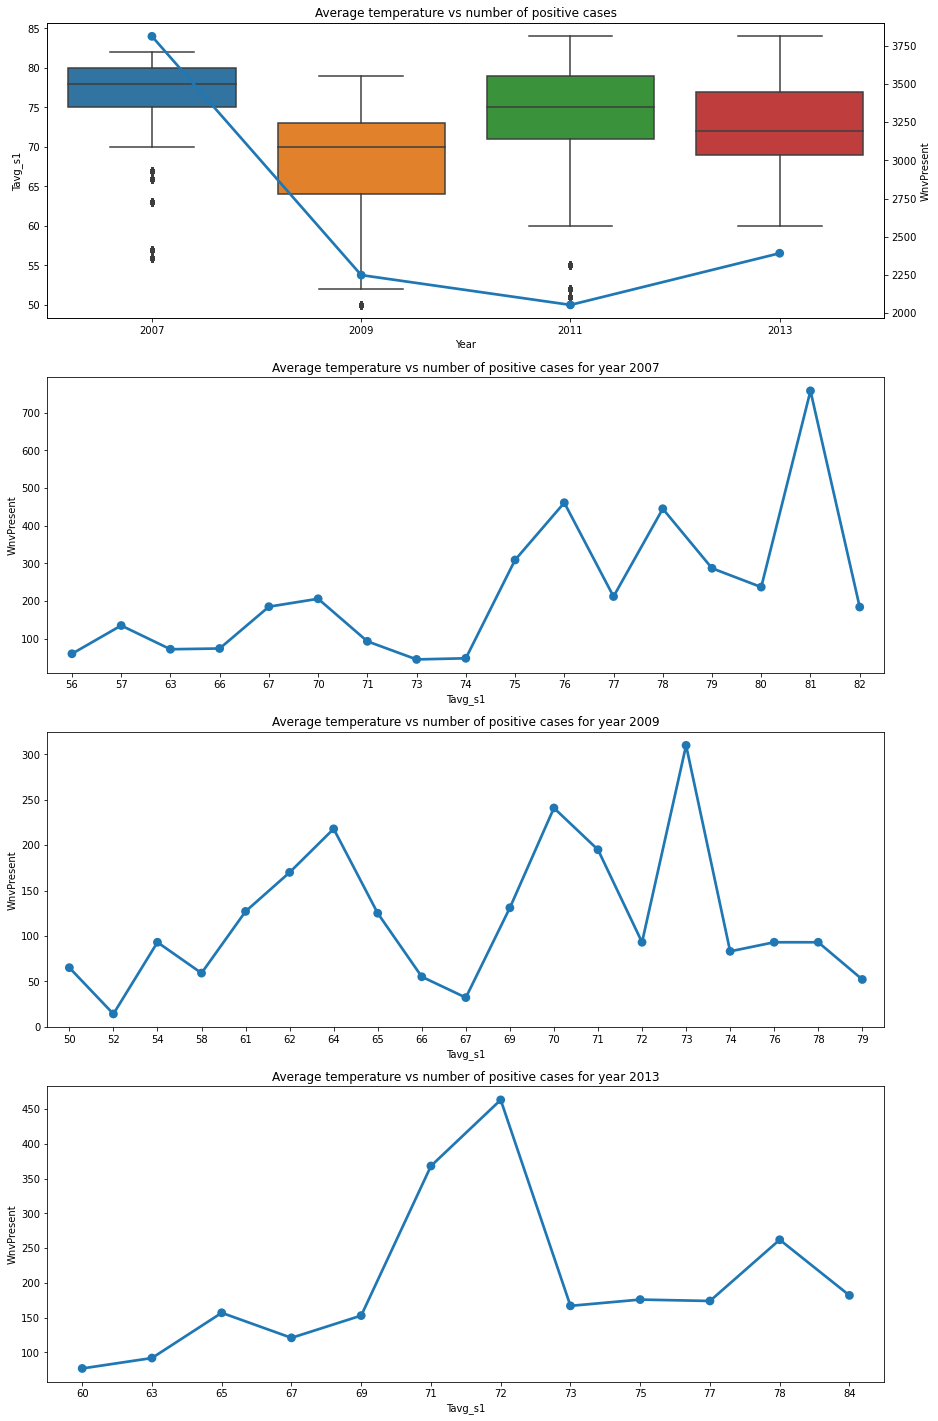

In [395]:
fig, ax = plt.subplots(4,1, figsize=(15,25))
ax1=ax[0]
ax2 = ax1.twinx()
temp=df_train.groupby('Year').count().reset_index()
sns.boxplot(df_train['Year'],df_train['Tavg_s1'], ax=ax1)
sns.pointplot(temp.Year,temp.WnvPresent,ax=ax2)
ax1.set_title('Average temperature vs number of positive cases')
temp1=df_train[df_train['Year']==2007].groupby(['Tavg_s1']).count().reset_index()
ax3=ax[1]
sns.pointplot(temp1.Tavg_s1,temp1.WnvPresent,ax=ax3)
ax3.set_title('Average temperature vs number of positive cases for year 2007')
ax4=ax[2]
temp2=df_train[df_train['Year']==2009].groupby(['Tavg_s1']).count().reset_index()
sns.pointplot(temp2.Tavg_s1,temp2.WnvPresent,ax=ax4)
ax4.set_title('Average temperature vs number of positive cases for year 2009')
ax5=ax[3]
temp3=df_train[df_train['Year']==2013].groupby(['Tavg_s1']).count().reset_index()
sns.pointplot(temp3.Tavg_s1,temp3.WnvPresent,ax=ax5)
ax5.set_title('Average temperature vs number of positive cases for year 2013')
plt.show()

### Visually, the higher the temperature, the more the infection!

<h3>Let's check effect of Moisture in the atmosphere by investigating DewPoint and WetBulb<h3>

Text(0.5, 1.0, 'Humidity vs number of positive cases')

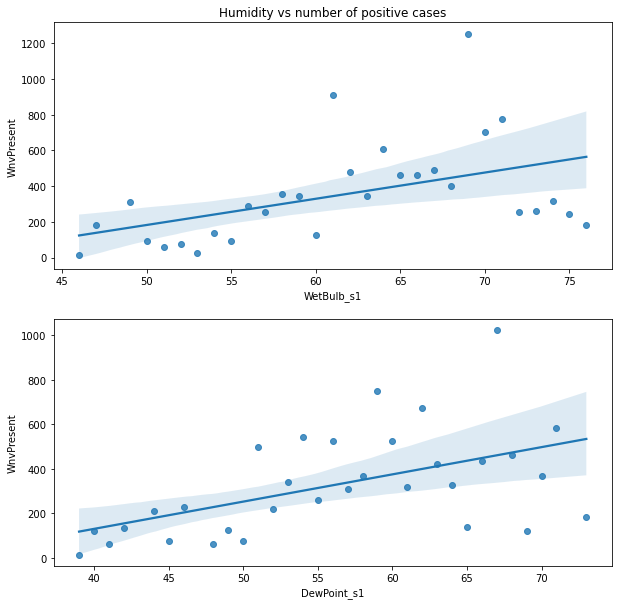

In [396]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
temp=df_train.groupby('DewPoint_s1').count().reset_index()
temp1=df_train.groupby('WetBulb_s1').count().reset_index()
ax1=ax[0]
sns.regplot(ax=ax1,x='WetBulb_s1',y='WnvPresent',data=temp1)
sns.regplot(ax=ax[1],x='DewPoint_s1',y='WnvPresent',data=temp)
ax1.set_title('Humidity vs number of positive cases')


<h4>It can be interpretted from the plots that higher the humidity, higher the presence of virus!<h4>

<h3>Let's check effect of day length by investigating 'Sunrise_s1', 'Sunset_s1'<h3>

In [397]:
Day_length=[]
for i in range (len(df_train.Sunrise_s1)):
    
    Q=df_train.Sunset_s1[i].astype('str').split()[0][0:2]+str((pd.to_numeric(df_train.Sunset_s1[i].astype('str').split()[0][2:])/60).astype('str').split()[0][1:])
    T=df_train.Sunrise_s1[i].astype('str').split()[0][0:1]+str((pd.to_numeric(df_train.Sunrise_s1[i].astype('str').split()[0][1:])/60).astype('str').split()[0][1:])

    Day_length.append(round(pd.to_numeric(Q)-pd.to_numeric(T),1))
df_train['Day_Length']=Day_length

In [398]:
df_train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day,...,WetBulb_s2,Heat_s2,Cool_s2,PrecipTotal_s2,StnPressure_s2,SeaLevel_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,Day_Length
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29,...,66,0,12,0.0,29.44,30.09,5.8,16,7.4,14.9
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29,...,66,0,12,0.0,29.44,30.09,5.8,16,7.4,14.9
2,2007-05-29,CULEX PIPIENS/RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,29,...,66,0,12,0.0,29.44,30.09,5.8,16,7.4,14.9
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5,29,...,66,0,12,0.0,29.44,30.09,5.8,16,7.4,14.9
4,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,4,0,2007,5,29,...,66,0,12,0.0,29.44,30.09,5.8,16,7.4,14.9


Text(0.5, 1.0, 'Correlation between day length and presence of infection')

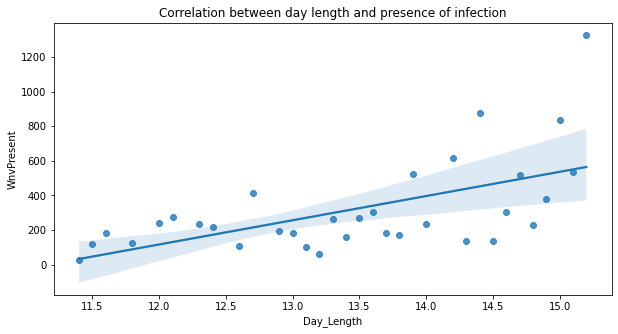

In [399]:
fig, ax = plt.subplots(figsize=(10,5))
temp=df_train.groupby('Day_Length').count().reset_index()
sns.regplot(x='Day_Length',y='WnvPresent',data=temp)
ax.set_title('Correlation between day length and presence of infection')

<h3>The posibility of infection increases with day time!

In [400]:
df_train['Depth_s1'].value_counts()

0    10506
Name: Depth_s1, dtype: int64

<h4> this feature must get droped!

In [401]:
df_train.drop('Depth_s1',axis=1,inplace=True)

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'PrecipTotal vs number of positive cases')

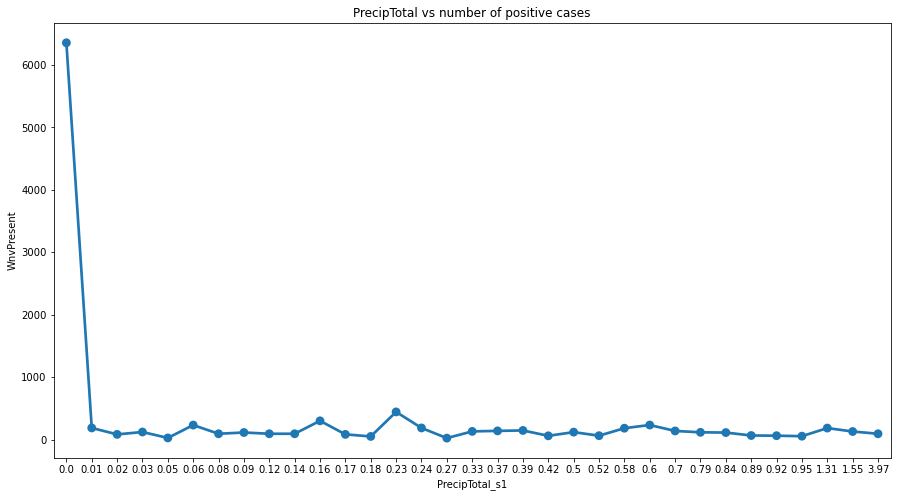

In [402]:
fig, ax = plt.subplots(figsize=(15,8))
temp=df_train.groupby('PrecipTotal_s1').count().reset_index()
sns.pointplot(temp.PrecipTotal_s1,temp.WnvPresent,ax=ax)
ax.set_title('PrecipTotal vs number of positive cases')

<h3>When it is zero, the chance of infection is so high!


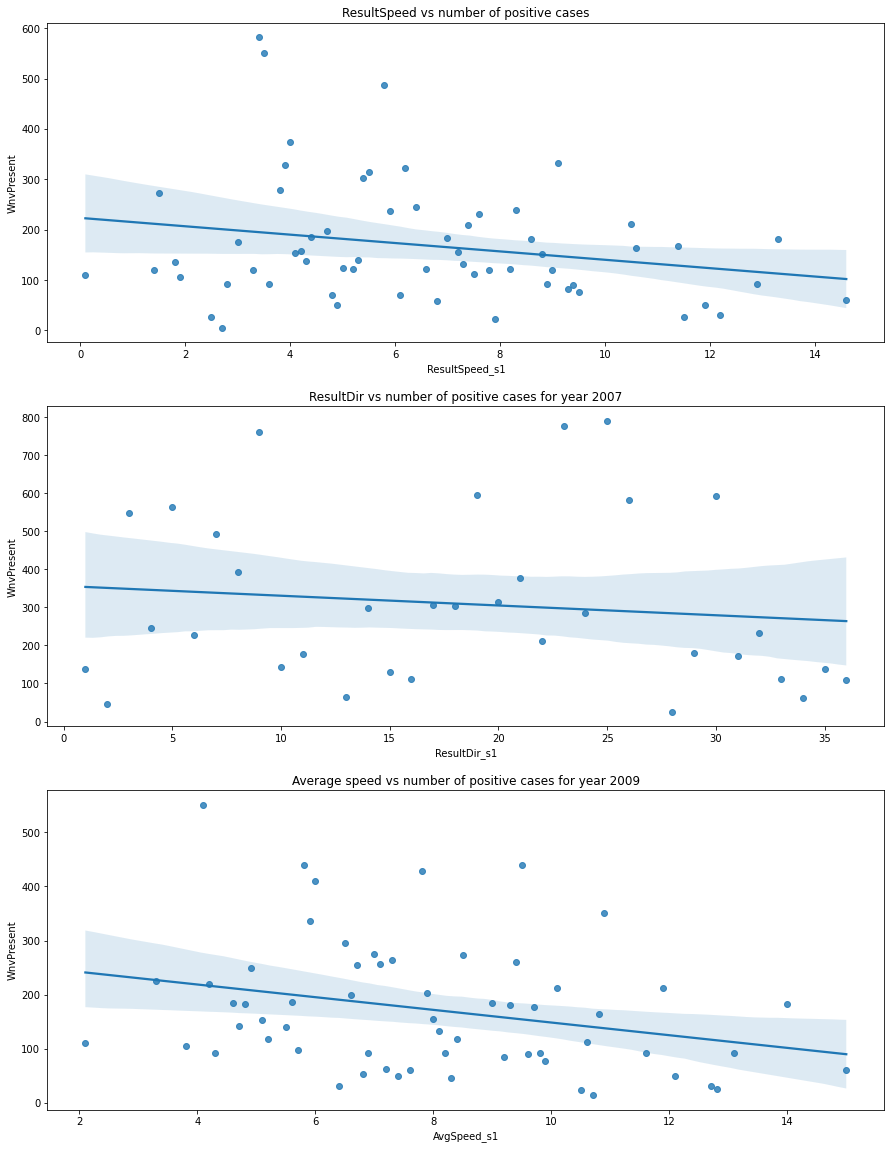

In [403]:
# Effect of wind speed and direction, and station pressure:
fig, ax = plt.subplots(3,1, figsize=(15,20))
ax1=ax[0]
temp=df_train.groupby('ResultSpeed_s1').count().reset_index()
sns.regplot(x='ResultSpeed_s1',y='WnvPresent',data=temp ,ax=ax1)

ax1.set_title('ResultSpeed vs number of positive cases')
temp1=df_train.groupby('ResultDir_s1').count().reset_index()
ax3=ax[1]
sns.regplot(x='ResultDir_s1',y='WnvPresent',data=temp1,ax=ax3)
ax3.set_title('ResultDir vs number of positive cases for year 2007')
ax4=ax[2]
temp2=df_train.groupby(['AvgSpeed_s1']).count().reset_index()
sns.regplot(x='AvgSpeed_s1',y='WnvPresent',data=temp2,ax=ax4)
ax4.set_title('Average speed vs number of positive cases for year 2009')
plt.show()

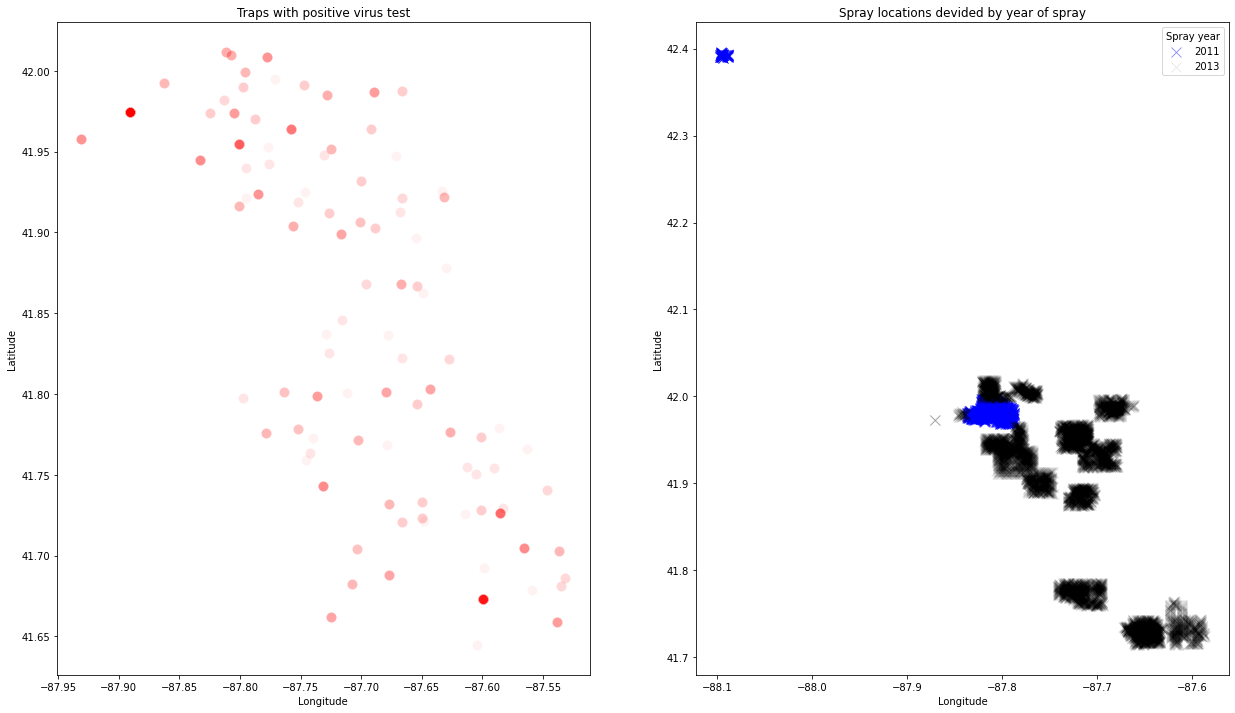

In [404]:
# Let's check the Traps with positive virus test with location of Spray
fig, ax = plt.subplots(1,2, figsize=(21,12))
sns.scatterplot(x='Longitude',y='Latitude',data=df_train[df_train['WnvPresent']==1],ax=ax[0],c=['red'], alpha=0.05,s=100)
ax[0].set_title('Traps with positive virus test')
sns.scatterplot(x='Longitude',y='Latitude',data=Spray[Spray['Year']==2011],ax=ax[1],c=['blue'], marker='x', alpha=0.5,legend=2011,s=100)
sns.scatterplot(x='Longitude',y='Latitude',data=Spray[Spray['Year']==2013],ax=ax[1],c=['black'], marker='x', alpha=0.1,legend=2013,s=100)
ax[1].set_title('Spray locations devided by year of spray')
ax[1].legend(title='Spray year', loc='upper right', labels=[2011,2013])

Text(0.5, 1.0, 'Maximum and minimum temperature vs number of positive cases')

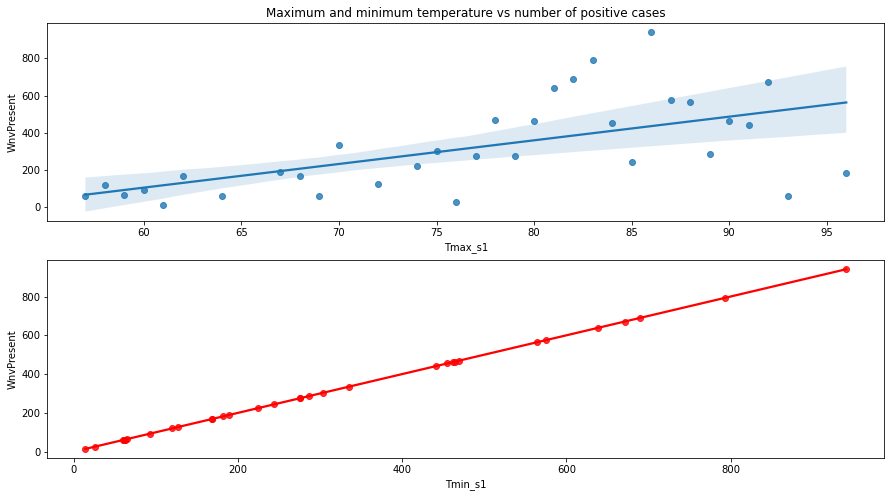

In [405]:
fig, ax = plt.subplots(2,1,figsize=(15,8))
temp=df_train.groupby('Tmax_s1').count().reset_index()
sns.regplot(x='Tmax_s1',y='WnvPresent',data=temp,ax=ax[0])
sns.regplot(x='Tmin_s1',y='WnvPresent',data=temp,ax=ax[1],color='red')
ax[0].set_title('Maximum and minimum temperature vs number of positive cases')

### These two features have both linear correlation with probability of infection

In [406]:
#Useful_features=['Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos','WnvPresent', 'Year', 'Month', 'Day', 'MP_Species','MP_Trap', 'MP_month', 'Tmax_s1', 'Tmin_s1', 'Tavg_s1','PrecipTotal_s1','Tmin_s2','Day_Length', 'DewPoint_s2', 'WetBulb_s2', 'Tavg_s2', 'PrecipTotal_s2']

In [407]:
df_train.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Year', 'Month', 'Day', 'MP_Species', 'Location',
       'MP_Trap', 'MP_month', 'Tmax_s1', 'Tmin_s1', 'Tavg_s1', 'Depart_s1',
       'DewPoint_s1', 'WetBulb_s1', 'Heat_s1', 'Cool_s1', 'Sunrise_s1',
       'Sunset_s1', 'PrecipTotal_s1', 'StnPressure_s1', 'SeaLevel_s1',
       'ResultSpeed_s1', 'ResultDir_s1', 'AvgSpeed_s1', 'Tmax_s2', 'Tmin_s2',
       'Tavg_s2', 'DewPoint_s2', 'WetBulb_s2', 'Heat_s2', 'Cool_s2',
       'PrecipTotal_s2', 'StnPressure_s2', 'SeaLevel_s2', 'ResultSpeed_s2',
       'ResultDir_s2', 'AvgSpeed_s2', 'Day_Length'],
      dtype='object')

In [408]:
ob_cols = df_train.columns[df_train.dtypes.eq('object')]
ob_cols

Index(['Species', 'Trap', 'Location'], dtype='object')

In [409]:
df_train.drop('Location',axis=1,inplace=True)

In [410]:
df=pd.get_dummies(df_train)

# Modeling

## Model evaluation function

In [411]:
class model_evaluation:
   
    def __init__(self, y_test, X_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        self.x_test = X_test
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        probability = lr.predict_proba(X_test)[:,1]
        roc_auc_score_ = roc_auc_score(y_test, probability)
        print ("roc_auc_score: {}"  .format(roc_auc_score_))

In [425]:
corrmat = df.corr()
columns = abs(corrmat['WnvPresent']).sort_values(ascending=False).head(46)
columns


WnvPresent                        1.000000
NumMosquitos                      0.196820
Sunrise_s1                        0.105227
Month                             0.100143
DewPoint_s1                       0.090460
WetBulb_s1                        0.082938
DewPoint_s2                       0.080873
WetBulb_s2                        0.077728
Day_Length                        0.077470
Tmin_s2                           0.074459
Tmin_s1                           0.072719
Sunset_s1                         0.068451
Tavg_s1                           0.066043
Tavg_s2                           0.062072
Longitude                         0.060345
Cool_s1                           0.058953
Heat_s1                           0.056813
Cool_s2                           0.056728
Depart_s1                         0.055436
Heat_s2                           0.052008
ResultSpeed_s1                    0.051177
Year                              0.050865
Tmax_s1                           0.050536
Tmax_s2    

In [426]:
X=df[[x for x in columns.index if x != 'WnvPresent']]
y=df['WnvPresent']

<AxesSubplot:>

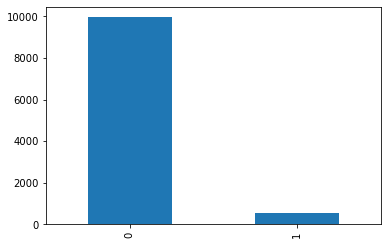

In [427]:
y.value_counts().plot.bar()

In [428]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print(Counter(y))
# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X, y)
# new class distribution
print(Counter(y_rus))

Counter({0: 9955, 1: 551})
Counter({0: 551, 1: 551})


In [429]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rus,
                                                    y_rus,
                                                    test_size=0.2,
                                                    random_state=42)

In [430]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [431]:
lr_model = LogisticRegression()

In [432]:
lr = LogisticRegression(solver="lbfgs",max_iter=100000)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test, X_test, predicted_lr)
lrg.confusion_matrix ()

True Negatives: 79
False Positives: 39
False Negatives: 31
True Positives: 72
Precision: 0.6486486486486487
Recall: 0.6990291262135923
F1 score: 0.6728971962616822
roc_auc_score: 0.7554303110087215


In [433]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_sample(X, y)

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WnvPresent', ylabel='count'>

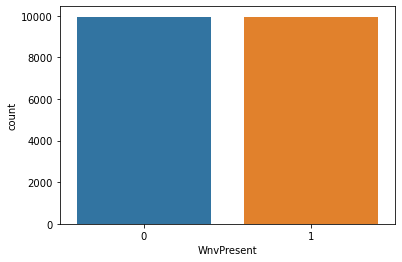

In [434]:
sns.countplot(oversampled_Y)

In [435]:

X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y,
                                                    test_size=0.4,
                                                    random_state=42)

In [436]:
lr = LogisticRegression(solver="lbfgs",max_iter=100000)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test, X_test, predicted_lr)
lrg.confusion_matrix ()

True Negatives: 3130
False Positives: 882
False Negatives: 706
True Positives: 3246
Precision: 0.7863372093023255
Recall: 0.8213562753036437
F1 score: 0.8034653465346534
roc_auc_score: 0.8831978886215847


In [437]:
from sklearn.ensemble import VotingClassifier
#soft voting usually have better performance than hard voting


log_clf = LogisticRegression(solver="lbfgs",max_iter=100000)
svm_clf = SVC(kernel = 'rbf', C = 1, probability=True)


pipeline = Pipeline([
    ('reduce_dims', PCA(n_components=5)),
    ('voting_clf', VotingClassifier(estimators=[("lr",log_clf), ("svm", svm_clf)], voting="soft"))])


PCA_LR_SVM = pipeline.fit(X_train, y_train) 
predict_PCA_LR_SVM = pipeline.predict(X_test) 

PCA_LRg = model_evaluation (y_test, X_test, predict_PCA_LR_SVM)
PCA_LRg.confusion_matrix ()

True Negatives: 3029
False Positives: 983
False Negatives: 778
True Positives: 3174
Precision: 0.7635313928313687
Recall: 0.8031376518218624
F1 score: 0.7828338882722902
roc_auc_score: 0.8831978886215847


<h3> So far, oversampling has proved promising performance. Now I'll do "Grid Search" for finding the best classification model. The models include Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, Extra Trees Classifier, Gradient Boosting and Ada Boost.

In [470]:
# Initialize dictionaries for models
model_dict = {
   'lr': LogisticRegression(),
   'knn': KNeighborsClassifier(),
   'dt': DecisionTreeClassifier(),
   'svm': SVC(),
   'rf' : RandomForestClassifier(n_estimators=100),
   'et' : ExtraTreesClassifier(n_estimators=100),
   'gbc' : GradientBoostingClassifier(n_estimators=100),
   'abc' : AdaBoostClassifier(n_estimators=100)
}

model_full = {
   'lr': 'Logistic Regression',
   'knn': 'KNearestNeighbor',
   'dt': 'DecisionTreeClassifier',
   'svm' : 'Support Vector Classifier',
   'rf' : 'Random Tree Classifier',
   'et' : 'Extra Tree Classifier',
   'gbc' : 'GradientBoostingClassifier',
   'abc' : 'AdaBoostClassifier'
}

# Initialize functions for pipeline
def prepare_pipeline(model):
    pipe_list = (model,model_dict[model])
    return Pipeline([pipe_list])

# Initialize functions for parameters
def prepare_params(model):
    if model == 'lr':
        return {'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear']
                }
    elif model == 'knn':
        return {'knn__n_neighbors' : [5,6]
                }
    elif model == 'dt':
        return {'dt__max_depth' : [3, 5],
                'dt__min_samples_split' : [5, 10],
                'dt__min_samples_leaf' : [2, 3]
                }  
    elif model == 'svm':
        return {'svm__gamma' : np.logspace(-5,2,2),
                'svm__C' : np.logspace(-3,2,2),
                'svm__kernel' : ['rbf', 'sigmoid']
                }
    elif model == 'rf':
        return {
                'rf__n_estimators': [100, 150, 200],
                'rf__max_depth': [3, 4, 5],
                'rf__min_samples_leaf' : [1,2,3]
                }
    elif model == 'et':
        return {
                'et__n_estimators': [100, 150, 200],
                'et__max_depth': [3, 4, 5],
                'et__min_samples_leaf' : [1,2,3]
                }
    elif model == 'gbc':
        return {
                'gbc__learning_rate': [0.1,0.2,0.5],
                'gbc__max_depth': [3, 4, 5],
                }
    elif model == 'abc':
        return {
                'abc__learning_rate': [0.2,0.5,0.73],
                }

# Initialize functions for grid search, calling on above functions, and printing model metrics
def grid_search(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,n_jobs=-1):
    pipe_params = prepare_params(model)
    pipe = prepare_pipeline(model)
    gs = GridSearchCV(pipe,param_grid=pipe_params,cv=3)
    gs.fit(X_train,y_train)
    print(f'Results from {model_full[model]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    print('\n')
    tn, fp, fn, tp = confusion_matrix(y_test, gs.best_estimator_.predict(X_test)).ravel()
    print('From Confusion Matrix:')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('\n')
    report = classification_report(y_test, gs.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
    class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
    return class_table

In [475]:
for key in model_dict.keys():
    grid_search(key)

C:\Users\Shaqayeq\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Shaqayeq\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Shaqayeq\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Shaqayeq\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Shaqayeq\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the numb

Results from Logistic Regression:
Train Score: 0.8156
Test Score: 0.8103
Using the following parameters: {'lr__solver': 'newton-cg'}


From Confusion Matrix:
True Negatives: 3147
False Positives: 865
False Negatives: 646
True Positives: 3306


Results from KNearestNeighbor:
Train Score: 0.8625
Test Score: 0.8722
Using the following parameters: {'knn__n_neighbors': 5}


From Confusion Matrix:
True Negatives: 3184
False Positives: 828
False Negatives: 190
True Positives: 3762


Results from DecisionTreeClassifier:
Train Score: 0.8178
Test Score: 0.823
Using the following parameters: {'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}


From Confusion Matrix:
True Negatives: 3005
False Positives: 1007
False Negatives: 403
True Positives: 3549


Results from Support Vector Classifier:
Train Score: 0.8172
Test Score: 0.8502
Using the following parameters: {'svm__C': 100.0, 'svm__gamma': 100.0, 'svm__kernel': 'rbf'}


From Confusion Matrix:
True Negatives: 3631
False 

In [474]:
model_dict.keys()

dict_keys(['lr', 'knn', 'dt', 'svm', 'rf', 'et', 'gbc', 'abc'])

# Prediction on Test dataset:

In [439]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115533 entries, 0 to 115532
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            115533 non-null  datetime64[ns]
 1   Species         115533 non-null  object        
 2   Trap            115533 non-null  object        
 3   Latitude        115533 non-null  float64       
 4   Longitude       115533 non-null  float64       
 5   Year            115533 non-null  int64         
 6   Month           115533 non-null  int64         
 7   Day             115533 non-null  int64         
 8   Station_s1      115533 non-null  int64         
 9   Tmax_s1         115533 non-null  int64         
 10  Tmin_s1         115533 non-null  int64         
 11  Tavg_s1         115533 non-null  int64         
 12  Depart_s1       115533 non-null  int64         
 13  DewPoint_s1     115533 non-null  int64         
 14  WetBulb_s1      115533 non-null  int

### Checking the match between the test dataset and train dataset, after joining with weather

In [450]:
df.columns

Index(['Date', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Year',
       'Month', 'Day', 'MP_Species', 'MP_Trap',
       ...
       'Trap_T230', 'Trap_T231', 'Trap_T232', 'Trap_T233', 'Trap_T235',
       'Trap_T236', 'Trap_T237', 'Trap_T238', 'Trap_T900', 'Trap_T903'],
      dtype='object', length=182)

In [458]:
Day_length=[]
for i in range (df_test.shape[0]):
    
    Q=df_test.Sunset_s1[i].astype('str').split()[0][0:2]+str((pd.to_numeric(df_test.Sunset_s1[i].astype('str').split()[0][2:])/60).astype('str').split()[0][1:])
    T=df_test.Sunrise_s1[i].astype('str').split()[0][0:1]+str((pd.to_numeric(df_test.Sunrise_s1[i].astype('str').split()[0][1:])/60).astype('str').split()[0][1:])

    Day_length.append(round(pd.to_numeric(Q)-pd.to_numeric(T),1))
df_test['Day_Length']=Day_length

In [459]:
Test.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year', 'Month',
       'Day'],
      dtype='object')

In [461]:
weather_cols=set(df_train.columns)-set(Train.columns)

In [456]:
useful_cols=list(Test.columns)+list(weather_cols)

In [462]:
df_test=df_test[useful_cols]